Twitter: [@ermeel_]( https://twitter.com/ermeel_)

In [1]:
%matplotlib inline

import pymc3 as pm
import theano.tensor as tt
import pandas as pd
import numpy as np
import seaborn as sns
import arviz as az
import matplotlib.pyplot as plt

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

np.random.seed(42)

In [2]:
print('Running on PyMC3 v{}'.format(pm.__version__))
print('Running on ArviZ v{}'.format(az.__version__))

Running on PyMC3 v3.6
Running on ArviZ v0.3.3


In [3]:
def linear_training_data(N=1000, weights=[1.0, -0.5], std=0.1):
    ncov = len(weights)
    weights = np.asarray(weights).reshape((ncov,1))
    X = np.random.uniform(size=(N,ncov))
    y = np.random.normal(loc=np.dot(X, weights), scale=std).flatten()
    return X,y

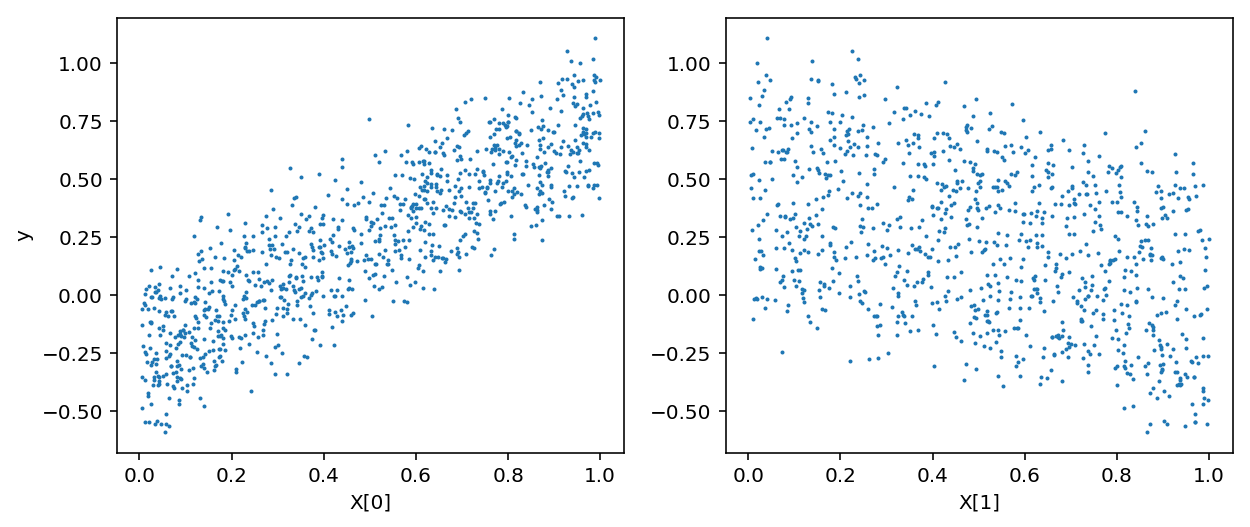

In [4]:
X,y = linear_training_data()
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10,4))
axes[0].scatter(X[:,0], y, s=1)
axes[1].scatter(X[:,1], y,s=1)
axes[0].set_ylabel('y'); axes[0].set_xlabel('X[0]'); axes[1].set_xlabel('X[1]');

In [5]:
with pm.Model() as linear_model:
    weights = pm.Normal('weights', mu=0, sd=1,shape=X.shape[1])
    noise = pm.Gamma('noise', alpha=2, beta=1)
    y_observed = pm.Normal('y_observed',
                mu=pm.math.dot(X,weights),
                sd=noise,
                observed=y)

    prior = pm.sample_prior_predictive()
    posterior = pm.sample(draws=2000,chains=4, cores=2, tune=1000)
    posterior_pred = pm.sample_posterior_predictive(posterior)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [noise, weights]
100%|██████████| 8000/8000 [00:05<00:00, 1531.03it/s]


In [6]:
data=az.from_pymc3(trace=posterior,
                     prior=prior,
                     posterior_predictive=posterior_pred
             )
az.to_netcdf(data, "linear_model_20190224.nc")
data

Inference data with groups:
	> posterior
	> sample_stats
	> posterior_predictive
	> prior
	> observed_data

In [7]:
az.summary(data, var_names=["weights", "noise"])

,mean,sd,mc error,hpd 3%,hpd 97%,ess,r_hat
weights[0],1.01,0.01,0.0,0.99,1.02,4118.0,1.0
weights[1],-0.51,0.01,0.0,-0.52,-0.49,4062.0,1.0
noise,0.10,0.00,0.0,0.09,0.10,6286.0,1.0


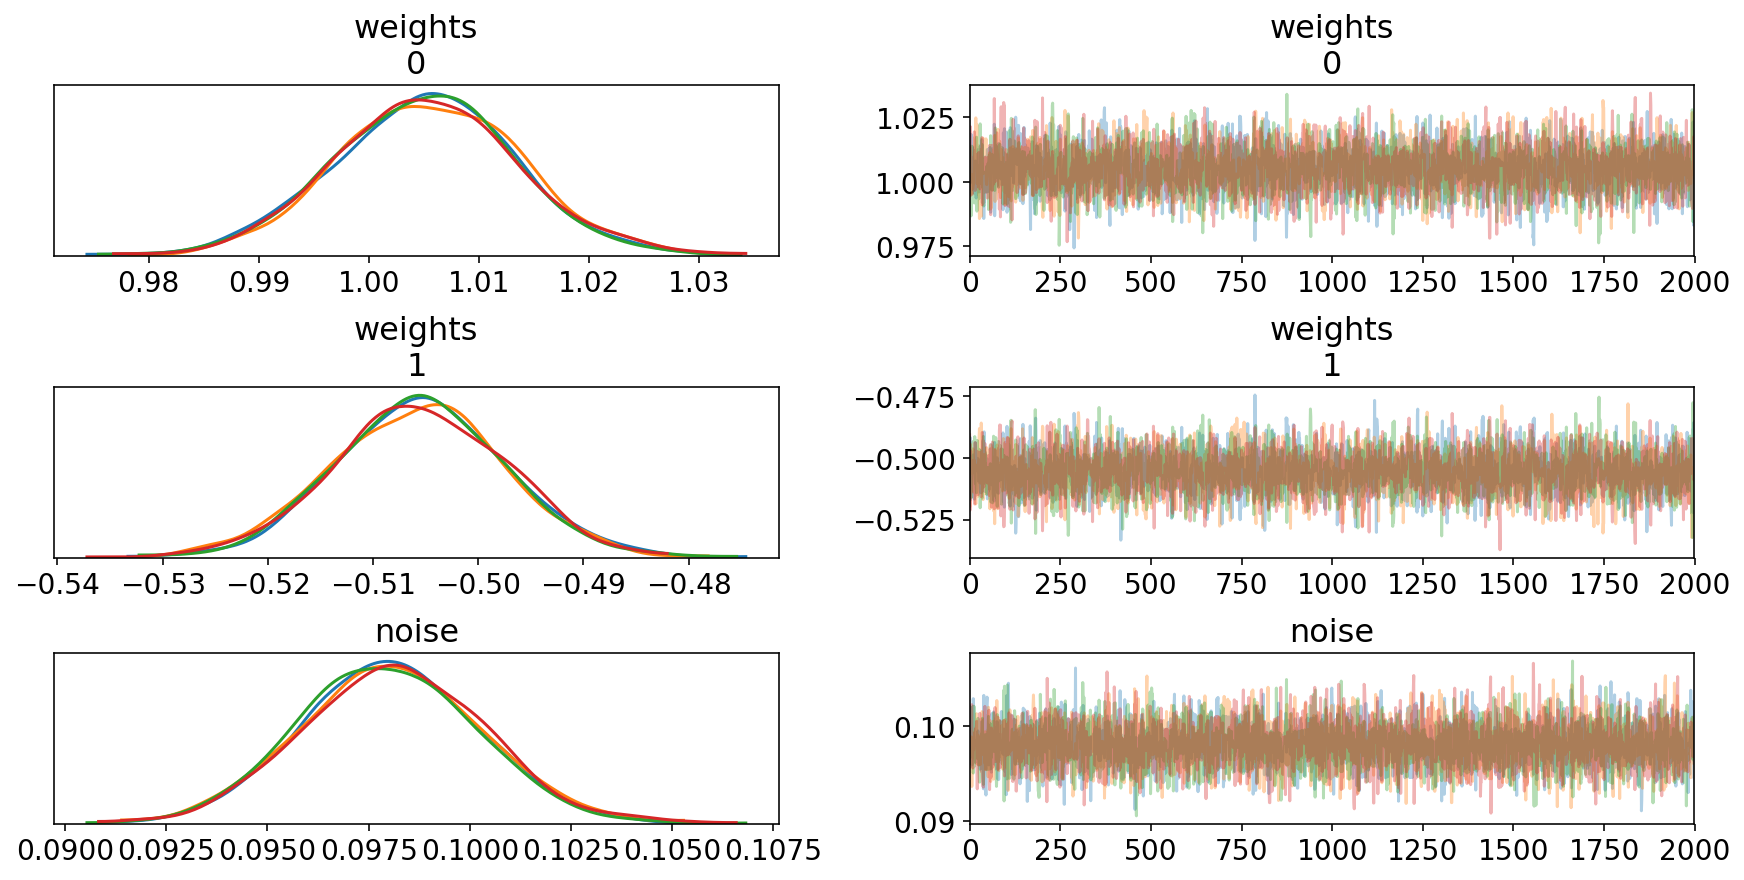

In [8]:
az.plot_trace(data);

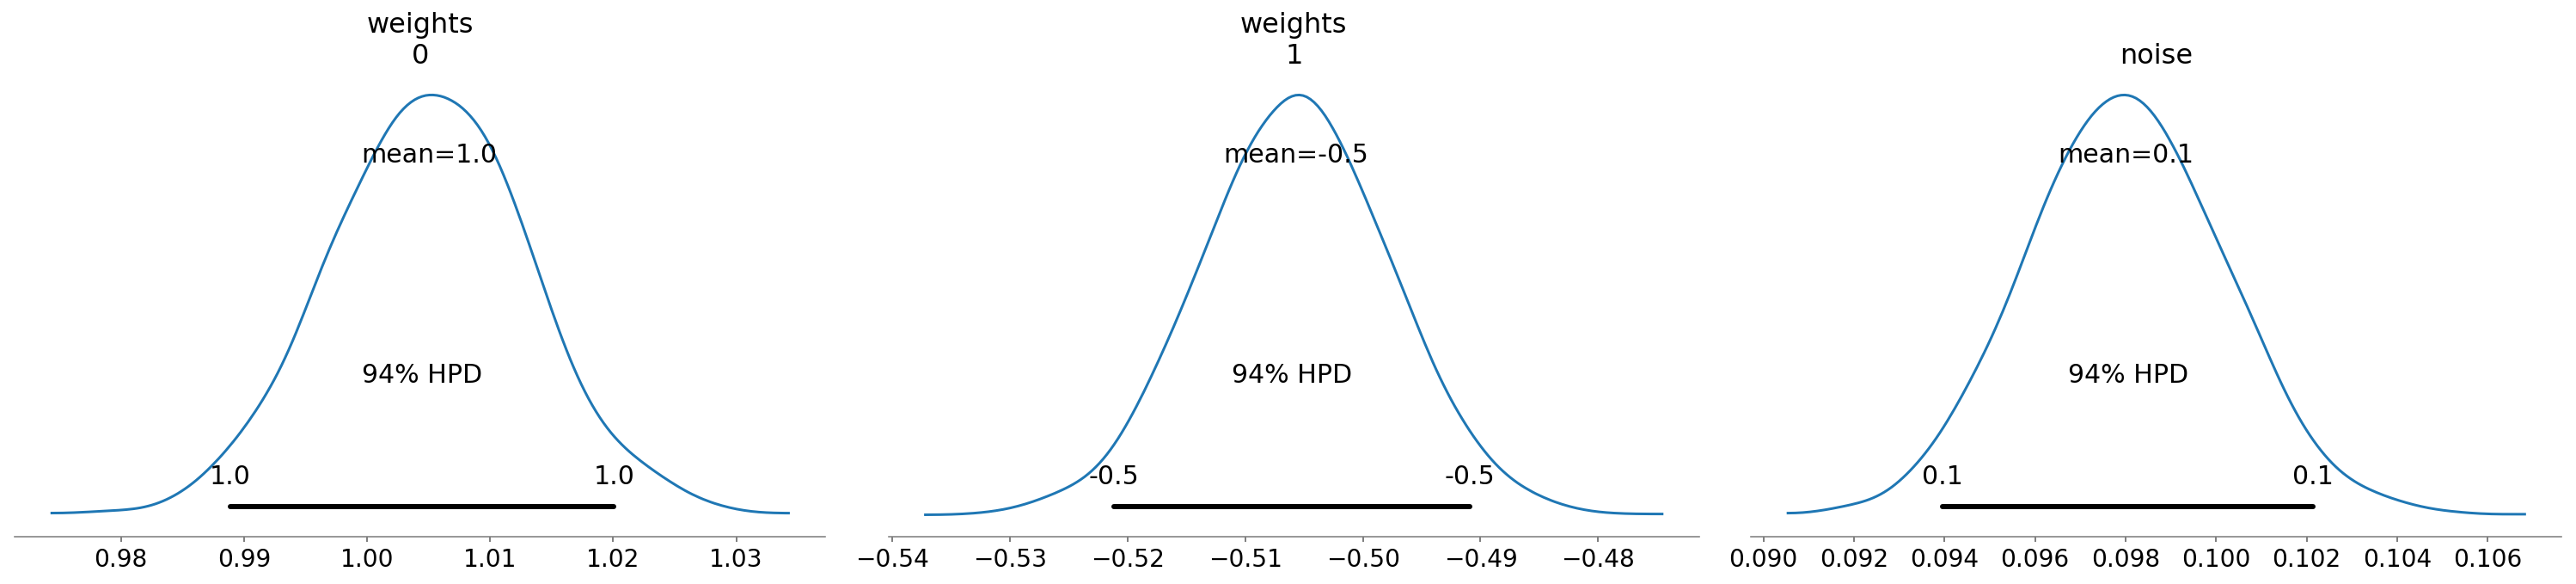

In [9]:
az.plot_posterior(data);

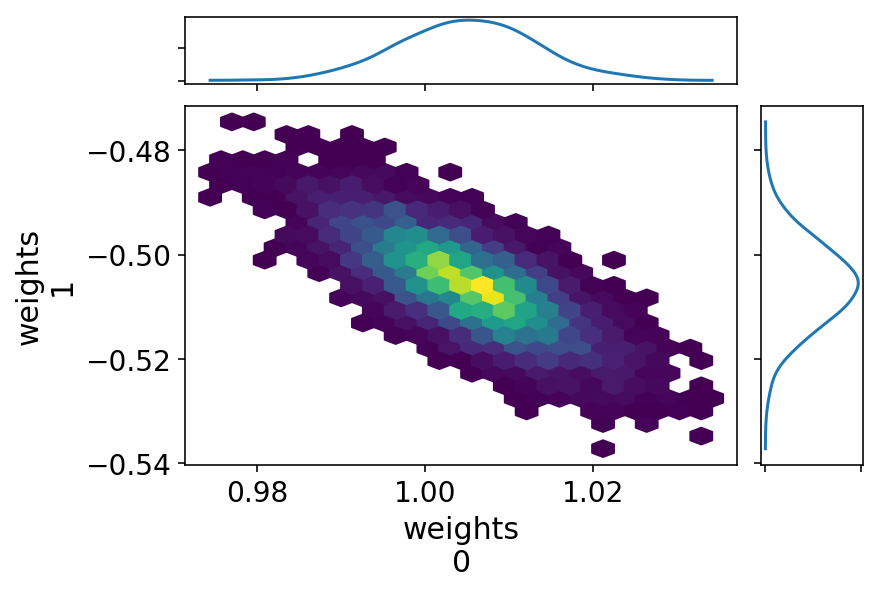

In [10]:
az.plot_joint(data,
              var_names=['weights'],
              kind='hexbin');

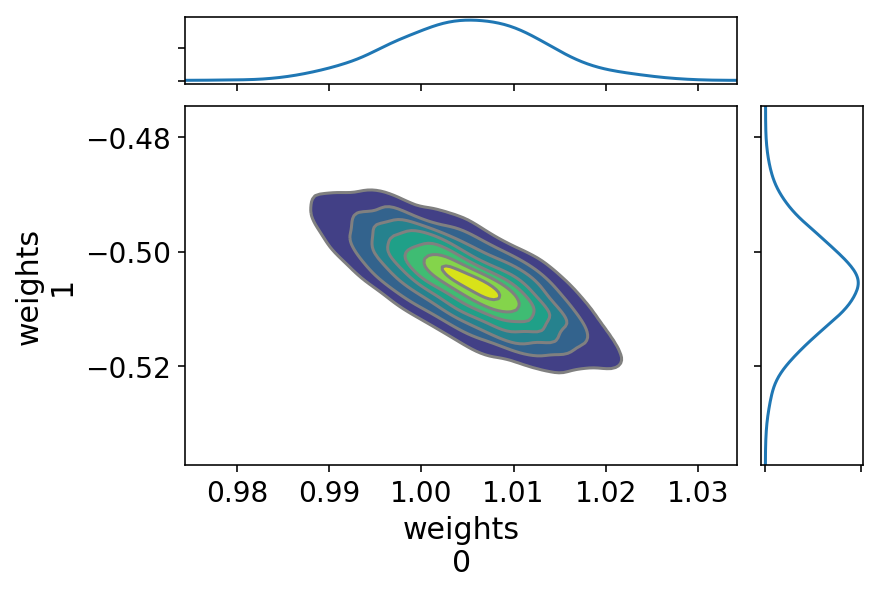

In [11]:
az.plot_joint(data, kind="kde", var_names=["weights"],fill_last=False);

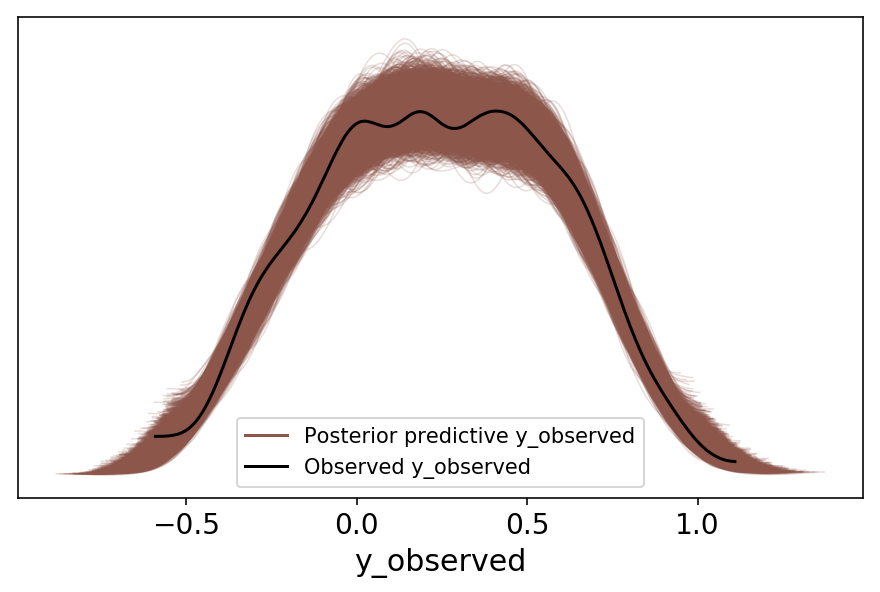

In [12]:
az.plot_ppc(data, mean=False);

In [13]:
loo = az.loo(data)
loo

loo           -1806.8
loo_se        46.4138
p_loo         2.98165
warning             0
loo_scale    deviance
dtype: object